In [1]:
import findspark
findspark.init('/home/ubuntu/spark-3.2.1-bin-hadoop2.7')
import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('DataPreparation').getOrCreate()

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/10/12 06:55:04 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


## 3.1	Data Selection 

In [16]:
# Load the filtered DataFrames back from CSV files
source1_df = spark.read.csv("US_Accidents_s1.csv", header=True)
source2_df = spark.read.csv("US_Accidents_s2.csv", header=True)
source3_df = spark.read.csv("US_Accidents_s3.csv", header=True)

# Data Integration - Append the DataFrames
df_la_accidents = source1_df.union(source2_df).union(source3_df)

# Show the resulting DataFrame
df_la_accidents.show()


+---------+-------+--------+-------------------+-------------------+------------------+-------------------+------------------+-----------+------------------+--------------------+---------------+-----------+-----------+-----+----------+-------+----------+------------+-------------------+--------------+-------------+-----------+------------+--------------+--------------+---------------+-----------------+-----------------+-------+-----+--------+--------+--------+-------+-------+----------+-------+-----+---------------+--------------+------------+--------------+--------------+-----------------+---------------------+
|       ID| Source|Severity|         Start_Time|           End_Time|         Start_Lat|          Start_Lng|           End_Lat|    End_Lng|      Distance(mi)|         Description|         Street|       City|     County|State|   Zipcode|Country|  Timezone|Airport_Code|  Weather_Timestamp|Temperature(F)|Wind_Chill(F)|Humidity(%)|Pressure(in)|Visibility(mi)|Wind_Direction|Wind_Spee

In [2]:
# Importing data which has a header. Schema is automatically configured.
df_la_accidents = spark.read.csv('LA_Accidents.csv', header=True, inferSchema=True)
# Let's see the data. You'll notice nulls.
df_la_accidents.show()

23/10/12 06:55:18 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-------+-------+--------+-------------------+-------------------+------------------+-----------+-------+-------+------------+--------------------+------------------+-----------+-----------+-----+----------+-------+----------+------------+-------------------+--------------+-------------+-----------+------------+--------------+--------------+---------------+-----------------+-----------------+-------+-----+--------+--------+--------+-------+-------+----------+-------+-----+---------------+--------------+------------+--------------+--------------+-----------------+---------------------+
|     ID| Source|Severity|         Start_Time|           End_Time|         Start_Lat|  Start_Lng|End_Lat|End_Lng|Distance(mi)|         Description|            Street|       City|     County|State|   Zipcode|Country|  Timezone|Airport_Code|  Weather_Timestamp|Temperature(F)|Wind_Chill(F)|Humidity(%)|Pressure(in)|Visibility(mi)|Wind_Direction|Wind_Speed(mph)|Precipitation(in)|Weather_Condition|Amenity| Bump

In [3]:
# Selecting Items/Rows. 
df_la_accidents.createOrReplaceTempView('la_accidents')
df_la_accidents = spark.sql("SELECT * FROM la_accidents WHERE city = 'Los Angeles'")
df_la_accidents.show()

+-------+-------+--------+-------------------+-------------------+------------------+-----------+-------+-------+------------+--------------------+------------------+-----------+-----------+-----+----------+-------+----------+------------+-------------------+--------------+-------------+-----------+------------+--------------+--------------+---------------+-----------------+-----------------+-------+-----+--------+--------+--------+-------+-------+----------+-------+-----+---------------+--------------+------------+--------------+--------------+-----------------+---------------------+
|     ID| Source|Severity|         Start_Time|           End_Time|         Start_Lat|  Start_Lng|End_Lat|End_Lng|Distance(mi)|         Description|            Street|       City|     County|State|   Zipcode|Country|  Timezone|Airport_Code|  Weather_Timestamp|Temperature(F)|Wind_Chill(F)|Humidity(%)|Pressure(in)|Visibility(mi)|Wind_Direction|Wind_Speed(mph)|Precipitation(in)|Weather_Condition|Amenity| Bump

In [4]:
#Selecting Attributes/Columns

selected_attribute_list=['ID', 
                               'Start_Time', 'End_Time',
                               'Source', 'Severity', 
                               'Wind_Direction', 'Weather_Condition', 'Amenity',
                               'Bump', 'Crossing', 'Give_Way', 'Junction',
                               'No_Exit', 'Railway', 'Roundabout', 'Station', 
                               'Stop', 'Traffic_Calming', 'Traffic_Signal', 
                               'Turning_Loop', 'Sunrise_Sunset', 'Civil_Twilight', 
                               'Nautical_Twilight', 'Astronomical_Twilight',
                               'Distance(mi)', 'Temperature(F)', 'Wind_Chill(F)', 
                               'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 
                               'Wind_Speed(mph)', 'Precipitation(in)']
# deleted features :'Start_Lng', 'End_Lat', 'Start_Lat', 'End_Lng', 'Description','Weather_Timestamp',
# 'City', 'County',  'State',  'Country', 'Timezone', 'Airport_Code','Zipcode', 'Street',
df_la_accidents = df_la_accidents.select(selected_attribute_list)

## 3.2	Data Cleaning

In [5]:
# show datatypes and null values
from pyspark.sql.functions import col, sum

df_la_accidents.printSchema()
null_statistics = df_la_accidents.select([sum(col(c).isNull().cast("int")).alias(c) for c in df_la_accidents.columns])
null_statistics.show()

root
 |-- ID: string (nullable = true)
 |-- Start_Time: string (nullable = true)
 |-- End_Time: string (nullable = true)
 |-- Source: string (nullable = true)
 |-- Severity: integer (nullable = true)
 |-- Wind_Direction: string (nullable = true)
 |-- Weather_Condition: string (nullable = true)
 |-- Amenity: boolean (nullable = true)
 |-- Bump: boolean (nullable = true)
 |-- Crossing: boolean (nullable = true)
 |-- Give_Way: boolean (nullable = true)
 |-- Junction: boolean (nullable = true)
 |-- No_Exit: boolean (nullable = true)
 |-- Railway: boolean (nullable = true)
 |-- Roundabout: boolean (nullable = true)
 |-- Station: boolean (nullable = true)
 |-- Stop: boolean (nullable = true)
 |-- Traffic_Calming: boolean (nullable = true)
 |-- Traffic_Signal: boolean (nullable = true)
 |-- Turning_Loop: boolean (nullable = true)
 |-- Sunrise_Sunset: string (nullable = true)
 |-- Civil_Twilight: string (nullable = true)
 |-- Nautical_Twilight: string (nullable = true)
 |-- Astronomical_Twilig

+---+----------+--------+------+--------+--------------+-----------------+-------+----+--------+--------+--------+-------+-------+----------+-------+----+---------------+--------------+------------+--------------+--------------+-----------------+---------------------+------------+--------------+-------------+-----------+------------+--------------+---------------+-----------------+
| ID|Start_Time|End_Time|Source|Severity|Wind_Direction|Weather_Condition|Amenity|Bump|Crossing|Give_Way|Junction|No_Exit|Railway|Roundabout|Station|Stop|Traffic_Calming|Traffic_Signal|Turning_Loop|Sunrise_Sunset|Civil_Twilight|Nautical_Twilight|Astronomical_Twilight|Distance(mi)|Temperature(F)|Wind_Chill(F)|Humidity(%)|Pressure(in)|Visibility(mi)|Wind_Speed(mph)|Precipitation(in)|
+---+----------+--------+------+--------+--------------+-----------------+-------+----+--------+--------+--------+-------+-------+----------+-------+----+---------------+--------------+------------+--------------+--------------+--

In [6]:
# using mean values to fill nan 
from pyspark.sql.functions import mean,count
for column_name in ['Temperature(F)', 'Wind_Chill(F)','Humidity(%)','Pressure(in)',
                   'Visibility(mi)','Wind_Speed(mph)','Precipitation(in)']:
    mean_value = df_la_accidents.select(mean(df_la_accidents[column_name])).collect()[0][0]
    df_la_accidents = df_la_accidents.na.fill(mean_value, subset=[column_name])
    
# using mode values to fill nan 
for column_name in ['Wind_Direction', 'Weather_Condition']:
    mode_result = df_la_accidents.groupBy(column_name).agg(count("*").alias("count")).sort(col("count").desc()).first()
    mode_value = mode_result[column_name]
    df_la_accidents = df_la_accidents.na.fill(mode_value, subset=[column_name])
    
# show df after filling na
null_statistics = df_la_accidents.select([sum(col(c).isNull().cast("int")).alias(c) for c in df_la_accidents.columns])
null_statistics.show()

+---+----------+--------+------+--------+--------------+-----------------+-------+----+--------+--------+--------+-------+-------+----------+-------+----+---------------+--------------+------------+--------------+--------------+-----------------+---------------------+------------+--------------+-------------+-----------+------------+--------------+---------------+-----------------+
| ID|Start_Time|End_Time|Source|Severity|Wind_Direction|Weather_Condition|Amenity|Bump|Crossing|Give_Way|Junction|No_Exit|Railway|Roundabout|Station|Stop|Traffic_Calming|Traffic_Signal|Turning_Loop|Sunrise_Sunset|Civil_Twilight|Nautical_Twilight|Astronomical_Twilight|Distance(mi)|Temperature(F)|Wind_Chill(F)|Humidity(%)|Pressure(in)|Visibility(mi)|Wind_Speed(mph)|Precipitation(in)|
+---+----------+--------+------+--------+--------------+-----------------+-------+----+--------+--------+--------+-------+-------+----------+-------+----+---------------+--------------+------------+--------------+--------------+--

In [7]:
for column_name in null_statistics.columns:
    column_data = null_statistics.select(column_name).rdd.flatMap(lambda x: x).collect()
    print(f"Column: {column_name}, Data: {column_data}")


Column: ID, Data: [0]
Column: Start_Time, Data: [0]
Column: End_Time, Data: [0]
Column: Source, Data: [0]
Column: Severity, Data: [0]
Column: Wind_Direction, Data: [0]
Column: Weather_Condition, Data: [0]
Column: Amenity, Data: [0]
Column: Bump, Data: [0]
Column: Crossing, Data: [0]
Column: Give_Way, Data: [0]
Column: Junction, Data: [0]
Column: No_Exit, Data: [0]
Column: Railway, Data: [0]
Column: Roundabout, Data: [0]
Column: Station, Data: [0]
Column: Stop, Data: [0]
Column: Traffic_Calming, Data: [0]
Column: Traffic_Signal, Data: [0]
Column: Turning_Loop, Data: [0]
Column: Sunrise_Sunset, Data: [0]
Column: Civil_Twilight, Data: [0]
Column: Nautical_Twilight, Data: [0]
Column: Astronomical_Twilight, Data: [0]
Column: Distance(mi), Data: [0]
Column: Temperature(F), Data: [0]
Column: Wind_Chill(F), Data: [0]
Column: Humidity(%), Data: [0]
Column: Pressure(in), Data: [0]
Column: Visibility(mi), Data: [0]
Column: Wind_Speed(mph), Data: [0]
Column: Precipitation(in), Data: [0]


In [8]:
# Dealing with extreme values 'Distance(mi)'
# Dealing with outliers filling with random value following the original distribution

import pyspark.sql.functions as F
from pyspark.sql import SparkSession
from pyspark.sql.types import DoubleType
from pyspark.sql.functions import udf
import numpy as np
import matplotlib.pyplot as plt

# Define the threshold for outliers
threshold = 1.0

# Identify outliers
outliers = df_la_accidents.filter(df_la_accidents["Distance(mi)"] > threshold)

# Calculate mean and standard deviation of non-outliers
non_outliers_stats = df_la_accidents.filter(df_la_accidents["Distance(mi)"] <= threshold).agg(
    F.mean("Distance(mi)").alias("mean"),
    F.stddev("Distance(mi)").alias("stddev")
).collect()

non_outliers_mean = non_outliers_stats[0]["mean"]
non_outliers_stddev = non_outliers_stats[0]["stddev"]

# Create a user-defined function (UDF) to generate random values following the original distribution
generate_random_udf = udf(
    lambda _: round(float(np.abs(np.random.normal(loc=non_outliers_mean, scale=non_outliers_stddev))),1), DoubleType())


df_la_accidents = df_la_accidents.withColumn("Distance(mi)", F.when(df_la_accidents["Distance(mi)"] > threshold, 
                           generate_random_udf(F.lit(0))).otherwise(df_la_accidents["Distance(mi)"]))
# Show the DataFrame after replacing outliers
df_la_accidents.show()

+-------+-------------------+-------------------+-------+--------+--------------+-----------------+-------+-----+--------+--------+--------+-------+-------+----------+-------+-----+---------------+--------------+------------+--------------+--------------+-----------------+---------------------+------------+--------------+-----------------+-----------+------------+--------------+------------------+--------------------+
|     ID|         Start_Time|           End_Time| Source|Severity|Wind_Direction|Weather_Condition|Amenity| Bump|Crossing|Give_Way|Junction|No_Exit|Railway|Roundabout|Station| Stop|Traffic_Calming|Traffic_Signal|Turning_Loop|Sunrise_Sunset|Civil_Twilight|Nautical_Twilight|Astronomical_Twilight|Distance(mi)|Temperature(F)|    Wind_Chill(F)|Humidity(%)|Pressure(in)|Visibility(mi)|   Wind_Speed(mph)|   Precipitation(in)|
+-------+-------------------+-------------------+-------+--------+--------------+-----------------+-------+-----+--------+--------+--------+-------+-------+

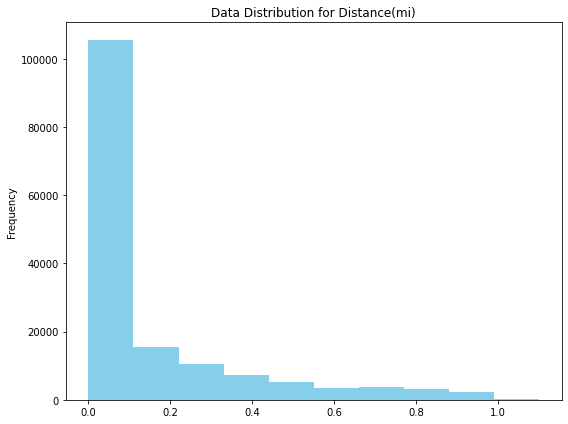

In [9]:
# Plot distribution of Distance(mi)
continuous_attributes = ['Distance(mi)']
plt.figure(figsize=(8, 6 * len(continuous_attributes)))

for i, column in enumerate(continuous_attributes):
    plt.subplot(len(continuous_attributes), 1, i + 1)
    ax = plt.gca()
    df_pd = df_la_accidents.select(column).toPandas()
    ax.hist(df_pd[column], color='skyblue')
    ax.set_ylabel('Frequency')
    ax.set_title(f'Data Distribution for {column}')

plt.tight_layout()
plt.show()


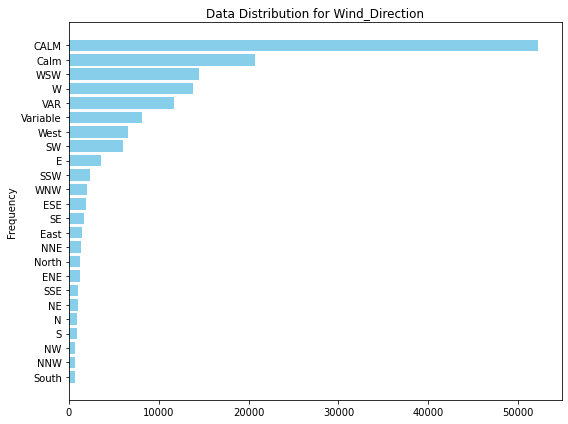

In [10]:
# show distribution of wind direction
category_attributes = ['Wind_Direction']
plt.figure(figsize=(8, 6 * len(category_attributes)))
for i, column in enumerate(category_attributes):
    plt.subplot(len(category_attributes), 1, i + 1)
    ax = plt.gca()
    
    value_counts = df_la_accidents.groupBy(column).count().orderBy(F.asc("count")).toPandas()
    ax.barh(value_counts[column], value_counts["count"], color='skyblue')
    ax.set_ylabel('Frequency')
    ax.set_title(f'Data Distribution for {column}')
    
plt.tight_layout()
plt.show()

In [11]:
# Replace coding inconsistencies in the 'Wind_Direction' column
value_mapping = {'East': 'E', 'West': 'W',"North":"N","South":"S","Variable":"V","Calm":"CALM"}

for original, replacement in value_mapping.items():
    df_la_accidents = df_la_accidents.withColumn(
        "Wind_Direction", F.when(df_la_accidents["Wind_Direction"] == original, replacement).otherwise(
            df_la_accidents["Wind_Direction"]))

## 3.3 Data Constructing

In [12]:
# Constructing ‘Weekday’ and ‘Hour’ Fields 

# Convert 'Start_Time' to a timestamp
df_la_accidents = df_la_accidents.withColumn("Start_Time", F.to_timestamp(df_la_accidents["Start_Time"]))
# Extract the weekday and hour into separate columns
df_la_accidents = df_la_accidents.withColumn("Weekday", F.dayofweek(df_la_accidents["Start_Time"]))  # Monday=2, Sunday=1
df_la_accidents = df_la_accidents.withColumn("Hour", F.hour(df_la_accidents["Start_Time"]))
# Show the DataFrame with weekday and hour columns
df_la_accidents.show()


+-------+-------------------+-------------------+-------+--------+--------------+-----------------+-------+-----+--------+--------+--------+-------+-------+----------+-------+-----+---------------+--------------+------------+--------------+--------------+-----------------+---------------------+------------+--------------+-----------------+-----------+------------+--------------+------------------+--------------------+-------+----+
|     ID|         Start_Time|           End_Time| Source|Severity|Wind_Direction|Weather_Condition|Amenity| Bump|Crossing|Give_Way|Junction|No_Exit|Railway|Roundabout|Station| Stop|Traffic_Calming|Traffic_Signal|Turning_Loop|Sunrise_Sunset|Civil_Twilight|Nautical_Twilight|Astronomical_Twilight|Distance(mi)|Temperature(F)|    Wind_Chill(F)|Humidity(%)|Pressure(in)|Visibility(mi)|   Wind_Speed(mph)|   Precipitation(in)|Weekday|Hour|
+-------+-------------------+-------------------+-------+--------+--------------+-----------------+-------+-----+--------+--------

In [13]:
df_la_accidents.select('Wind_Direction', 'Weather_Condition','Temperature(F)', 'Wind_Chill(F)','Humidity(%)',"Start_Time","Weekday","Hour").show()

+--------------+-----------------+--------------+-----------------+-----------+-------------------+-------+----+
|Wind_Direction|Weather_Condition|Temperature(F)|    Wind_Chill(F)|Humidity(%)|         Start_Time|Weekday|Hour|
+--------------+-----------------+--------------+-----------------+-----------+-------------------+-------+----+
|             V|            Clear|          82.9|64.92501173068268|       47.0|2016-06-21 10:46:30|      3|  10|
|             V|            Clear|          82.9|64.92501173068268|       47.0|2016-06-21 10:49:21|      3|  10|
|             V|            Clear|          82.9|64.92501173068268|       47.0|2016-06-21 10:51:45|      3|  10|
|             V|            Clear|          82.9|64.92501173068268|       47.0|2016-06-21 10:56:24|      3|  10|
|           ESE|            Clear|          80.1|64.92501173068268|       52.0|2016-06-21 11:30:46|      3|  11|
|            SW|            Clear|          79.0|64.92501173068268|       58.0|2016-06-21 11:59:

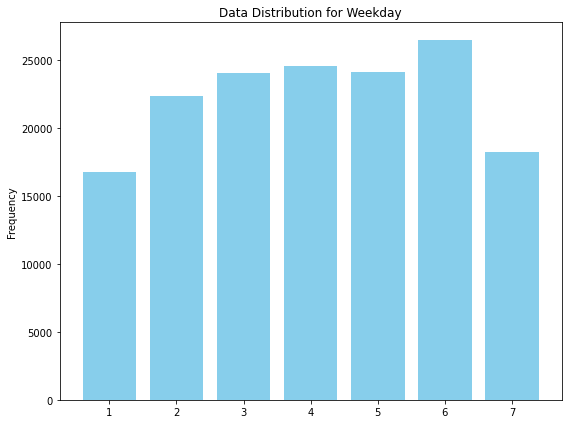

In [14]:

category_attributes = ['Weekday']
plt.figure(figsize=(8, 6 * len(category_attributes)))

for i, column in enumerate(category_attributes):
    plt.subplot(len(category_attributes), 1, i + 1)
    ax = plt.gca()
    
    value_counts = df_la_accidents.groupBy(column).count().orderBy(column).toPandas()
    ax.bar([str(i) for i in value_counts[column]], value_counts["count"], color='skyblue')
    ax.set_ylabel('Frequency')
    ax.set_title(f'Data Distribution for {column}')
    
plt.tight_layout()
plt.show()

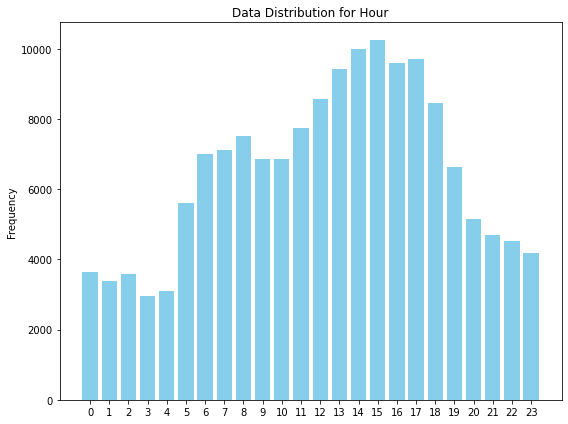

In [15]:
category_attributes = ['Hour']
plt.figure(figsize=(8, 6 * len(category_attributes)))

for i, column in enumerate(category_attributes):
    plt.subplot(len(category_attributes), 1, i + 1)
    ax = plt.gca()
    
    value_counts = df_la_accidents.groupBy(column).count().orderBy(column).toPandas()
    ax.bar([str(i) for i in value_counts[column]], value_counts["count"], color='skyblue')
    ax.set_ylabel('Frequency')
    ax.set_title(f'Data Distribution for {column}')
    
plt.tight_layout()
plt.show()

## 3.4	Data Integration 

In [2]:
# run in the first part
# Load the filtered DataFrames back from CSV files
source1_df = spark.read.csv("US_Accidents_s1.csv", header=True)
source2_df = spark.read.csv("US_Accidents_s2.csv", header=True)
source3_df = spark.read.csv("US_Accidents_s3.csv", header=True)

# Data Integration - Append the DataFrames
df_la_accidents = source1_df.union(source2_df).union(source3_df)

# Show the resulting DataFrame
df_la_accidents.show()


23/10/12 06:44:11 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [17]:
columns_to_drop = ["ID", "Start_Time", "End_Time", "Source"]
df_la_accidents = df_la_accidents.drop(*columns_to_drop)

# Save the preprocessed data as a CSV file
df_la_accidents.write.csv("LA_Accidents_preprocessed_pyspark.csv", header=True, mode="overwrite")